In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import argparse
import numpy as np
import matplotlib.pyplot as plt
from utils.model import CNN
from utils.loader import dataset_loader
from tqdm import tqdm

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=999)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--epochs', type=int, default=200)
parser.add_argument('--dim', type=int, default=128)
args = parser.parse_args([])

In [3]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)
torch.backends.cudnn.deterministic = True

In [5]:
train_dataset, val_dataset = dataset_loader()
test_dataset = dataset_loader(train=False)

Files already downloaded and verified
Dataset size: Train(40000), Val(10000)
Dataset size: Test(10000)


In [6]:
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2, drop_last=False)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = CNN(dim=args.dim).to(device)
model = nn.DataParallel(model, device_ids=[0,1])

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

cuda


In [9]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, args.epochs+1):
  model.train()
  loop = tqdm(train_loader, desc=f'Train (epoch {epoch}): ')
  losses = []
  correct, num = 0, 0
  for inputs, labels in loop:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    optimizer.zero_grad()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    correct += (torch.argmax(outputs, dim=1)==labels).sum().item()
    num += len(labels)

  train_losses.append(np.average(losses))
  train_accs.append(float(correct/num))
  print(f'Train ({epoch}/{args.epochs}) loss: {train_losses[-1]}, acc: {train_accs[-1]}')

  model.eval()
  loop = tqdm(val_loader, desc=f'Val (epoch {epoch}): ')
  losses = []
  correct, num = 0, 0
  with torch.no_grad():
    for inputs, labels in loop:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      losses.append(loss.item())
      correct += (torch.argmax(outputs, dim=1)==labels).sum().item()
      num += len(labels)

  val_losses.append(np.average(losses))
  val_accs.append(float(correct/num))
  print(f'Val ({epoch}/{args.epochs}) loss: {val_losses[-1]}, acc: {val_accs[-1]}')

Train (epoch 1): 100%|██████████| 78/78 [00:14<00:00,  5.42it/s]


Train (1/200) loss: 2.149374755529257, acc: 0.19195713141025642


Val (epoch 1): 100%|██████████| 20/20 [00:01<00:00, 11.28it/s]


Val (1/200) loss: 2.346439504623413, acc: 0.1738


Train (epoch 2): 100%|██████████| 78/78 [00:12<00:00,  6.26it/s]


Train (2/200) loss: 1.6649983815657787, acc: 0.36400741185897434


Val (epoch 2): 100%|██████████| 20/20 [00:01<00:00, 11.16it/s]


Val (2/200) loss: 1.790119481086731, acc: 0.3534


Train (epoch 3): 100%|██████████| 78/78 [00:12<00:00,  6.21it/s]


Train (3/200) loss: 1.4307946623899999, acc: 0.4567307692307692


Val (epoch 3): 100%|██████████| 20/20 [00:01<00:00, 11.39it/s]


Val (3/200) loss: 1.537932813167572, acc: 0.4341


Train (epoch 4): 100%|██████████| 78/78 [00:12<00:00,  6.18it/s]


Train (4/200) loss: 1.2399170429278643, acc: 0.5397636217948718


Val (epoch 4): 100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Val (4/200) loss: 1.2979853570461273, acc: 0.5309


Train (epoch 5): 100%|██████████| 78/78 [00:12<00:00,  6.16it/s]


Train (5/200) loss: 1.0684190484193654, acc: 0.6104767628205128


Val (epoch 5): 100%|██████████| 20/20 [00:01<00:00, 11.33it/s]


Val (5/200) loss: 1.2373834490776061, acc: 0.5508


Train (epoch 6): 100%|██████████| 78/78 [00:12<00:00,  6.12it/s]


Train (6/200) loss: 0.9364746587398725, acc: 0.6610576923076923


Val (epoch 6): 100%|██████████| 20/20 [00:01<00:00, 11.20it/s]


Val (6/200) loss: 1.0505111932754516, acc: 0.6188


Train (epoch 7): 100%|██████████| 78/78 [00:12<00:00,  6.10it/s]


Train (7/200) loss: 0.8522918766889817, acc: 0.6906800881410257


Val (epoch 7): 100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


Val (7/200) loss: 0.9931414544582366, acc: 0.6517


Train (epoch 8):  91%|█████████ | 71/78 [00:11<00:01,  6.02it/s]

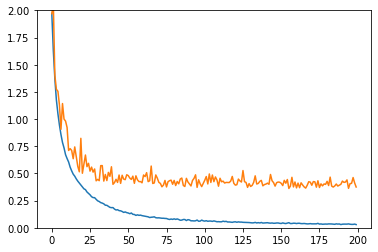

In [40]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.ylim([0,2])
plt.show()

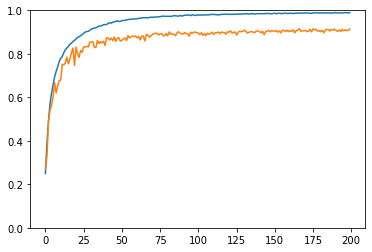

In [41]:
plt.plot(train_accs)
plt.plot(val_accs)
plt.ylim([0,1])
plt.show()

In [42]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [43]:
results = torch.zeros((2, len(classes)), dtype=int)
model.eval()
with torch.no_grad():
  for (inputs, labels) in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    preds = torch.argmax(outputs, dim=1)
    for pred, label in zip(preds, labels):
      results[1][int(label)] += 1
      if pred == label:
        results[0][int(label)] += 1

In [44]:
for (clas, correct, summ) in zip(classes, results[0], results[1]):
    print(f'{clas}: {correct}/{summ} ({correct/summ*100:.2f}%)')
print(f'\nSUM: {results[0].sum()}/{results[1].sum()} ({results[0].sum()/results[1].sum()*100:.2f}%)')

plane: 934/1000 (93.40%)
car: 968/1000 (96.80%)
bird: 905/1000 (90.50%)
cat: 784/1000 (78.40%)
deer: 935/1000 (93.50%)
dog: 936/1000 (93.60%)
frog: 933/1000 (93.30%)
horse: 949/1000 (94.90%)
ship: 956/1000 (95.60%)
truck: 955/1000 (95.50%)

SUM: 9255/10000 (92.55%)
